In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashwatwork/consume-complaints-dataset-fo-nlp")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/consume-complaints-dataset-fo-nlp


In [2]:
!pip install cleantext

In [183]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from cleantext import clean
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras_nlp
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.initializers import Constant
sns.set()

In [4]:
os.listdir('/kaggle/input/consume-complaints-dataset-fo-nlp')

['complaints_processed.csv']

In [5]:
df = pd.read_csv('/kaggle/input/consume-complaints-dataset-fo-nlp/complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [6]:
df.shape

(162421, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [8]:
df.isnull().sum()

Unnamed: 0     0
product        0
narrative     10
dtype: int64

In [9]:
df.dropna(inplace = True)

In [10]:
df.apply(pd.isnull).sum()

Unnamed: 0    0
product       0
narrative     0
dtype: int64

In [11]:
df.shape

(162411, 3)

In [12]:
df.duplicated().sum()

0

In [13]:
df['product'].value_counts()

product
credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: count, dtype: int64

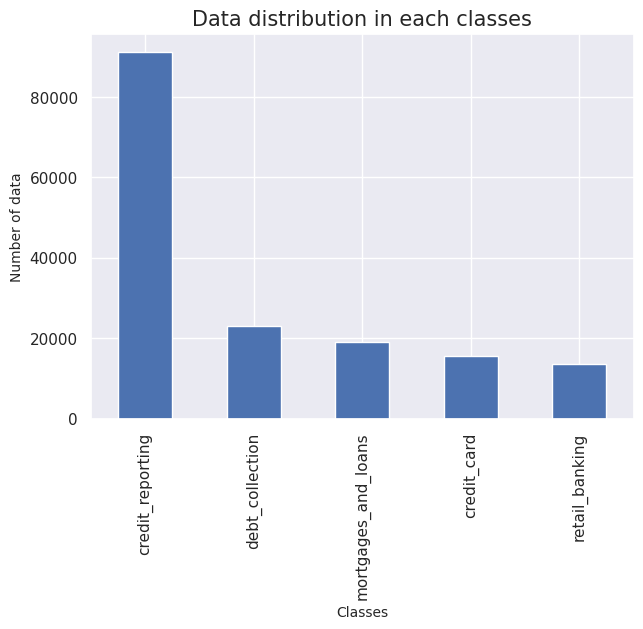

In [14]:
df['product'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.title('Data distribution in each classes', fontsize = 15)
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Number of data', fontsize = 10)
plt.show()

In [15]:
df1 = df[df['product'] == 'credit_reporting'].sample(1000)
df2 = df[df['product'] == 'debt_collection'].sample(1000)
df3 = df[df['product'] == 'mortgages_and_loans'].sample(1000)
df4 = df[df['product'] == 'credit_card'].sample(1000)
df5 = df[df['product'] == 'retail_banking'].sample(1000)

In [16]:
df_balanced = pd.concat([df1, df2, df3, df4, df5])
df_balanced.head()

,Unnamed: 0,product,narrative
109823,109823,credit_reporting,denied auto loan due negative account appearin...
87615,87615,credit_reporting,im writing credit bureau complete investigatio...
93482,93482,credit_reporting,chance look credit report found derogatory acc...
98037,98037,credit_reporting,credit report reflect loan payment fact date c...
36769,36769,credit_reporting,called transunion customer service would help ...


In [17]:
df_balanced.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

In [18]:
df_balanced.reset_index(drop = True, inplace = True)

In [19]:
df_balanced.head()

,product,narrative
0,credit_reporting,denied auto loan due negative account appearin...
1,credit_reporting,im writing credit bureau complete investigatio...
2,credit_reporting,chance look credit report found derogatory acc...
3,credit_reporting,credit report reflect loan payment fact date c...
4,credit_reporting,called transunion customer service would help ...


In [20]:
df_balanced.shape

(5000, 2)

In [21]:
df_balanced['product'].value_counts()

product
credit_reporting       1000
debt_collection        1000
mortgages_and_loans    1000
credit_card            1000
retail_banking         1000
Name: count, dtype: int64

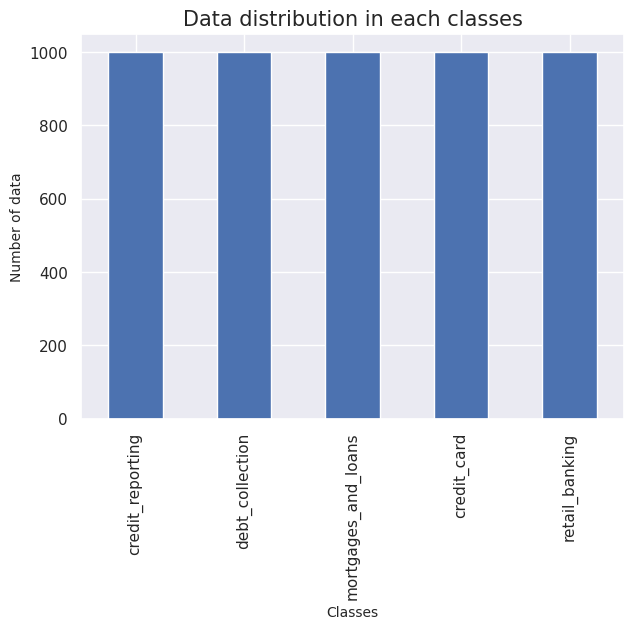

In [22]:
df_balanced['product'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.title('Data distribution in each classes', fontsize = 15)
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Number of data', fontsize = 10)
plt.show()

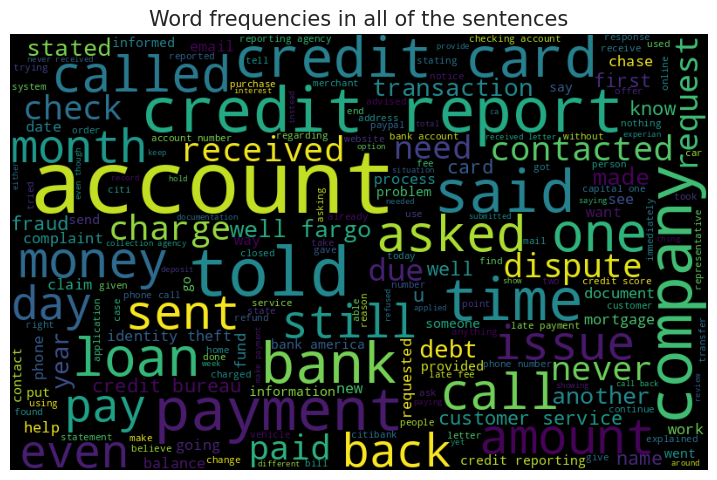

In [23]:
plt.figure(figsize = (9, 7))
all_sents = ' '.join([i for i in df_balanced['narrative']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
plt.imshow(word_cloud)
plt.title('Word frequencies in all of the sentences', fontsize = 15)
plt.axis('off')
plt.show()

In [24]:
def word_cloud(data, product):
    plt.figure(figsize = (9, 7))
    all_sents = ' '.join([i for i in data['narrative'][data['product'] == product]])
    wordcloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

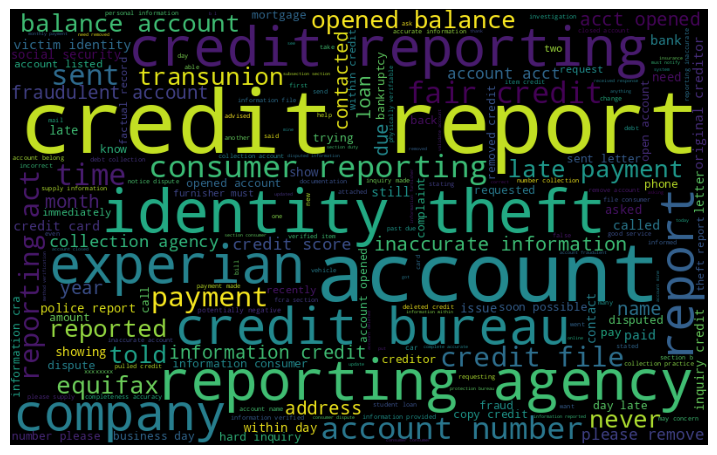

In [25]:
word_cloud(df_balanced, 'credit_reporting')

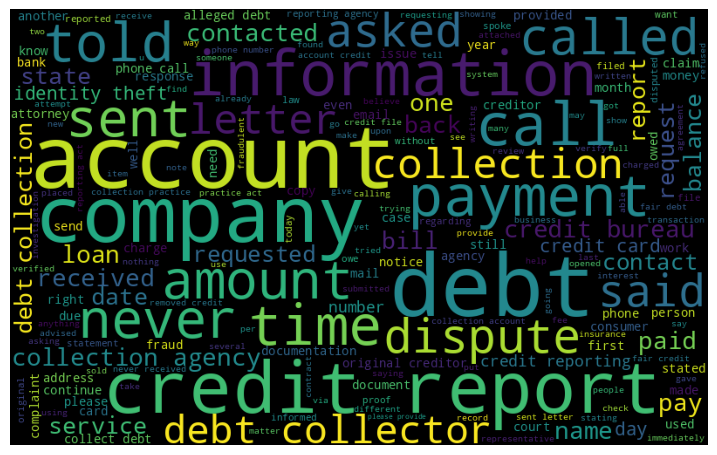

In [26]:
word_cloud(df_balanced, 'debt_collection')

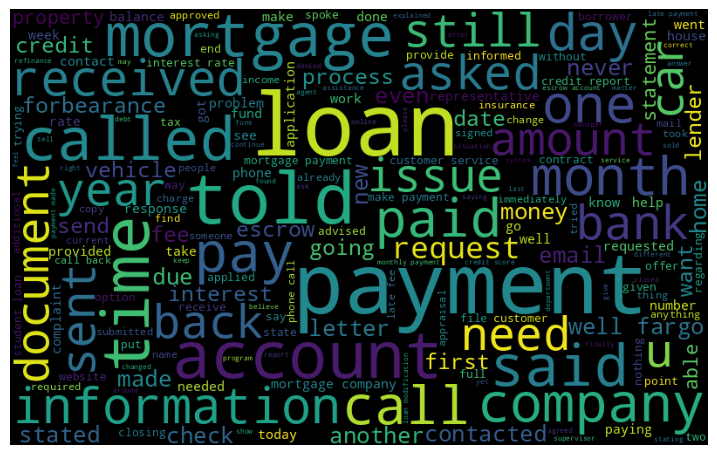

In [27]:
word_cloud(df_balanced, 'mortgages_and_loans')

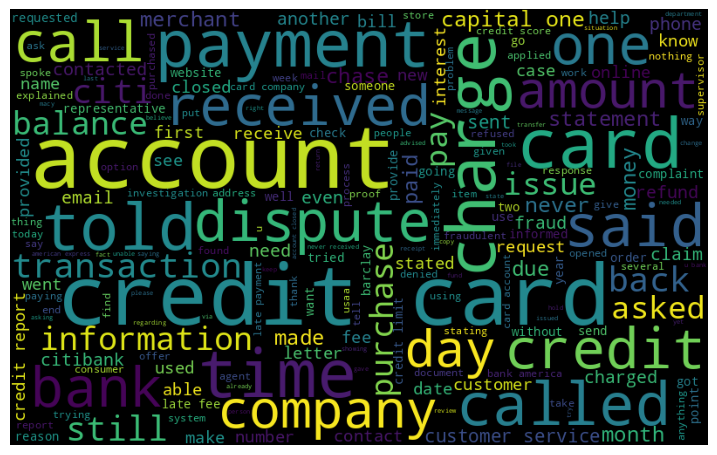

In [28]:
word_cloud(df_balanced, 'credit_card')

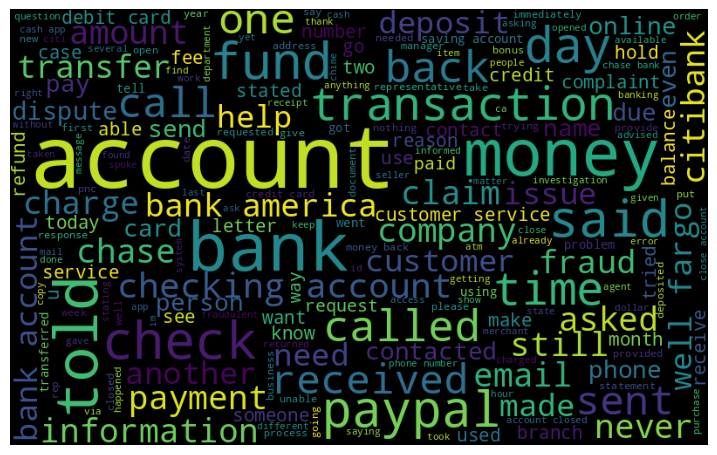

In [29]:
word_cloud(df_balanced, 'retail_banking')

In [30]:
df_balanced['cleaned_text'] = df_balanced['narrative'].apply(clean)

In [31]:
df_balanced.head()

,product,narrative,cleaned_text
0,credit_reporting,denied auto loan due negative account appearin...,deni auto loan due neg account appear credit r...
1,credit_reporting,im writing credit bureau complete investigatio...,im write credit bureau complet investig sent l...
2,credit_reporting,chance look credit report found derogatory acc...,chanc look credit report found derogatori acco...
3,credit_reporting,credit report reflect loan payment fact date c...,credit report reflect loan payment fact date c...
4,credit_reporting,called transunion customer service would help ...,call transunion custom servic would help take ...


In [32]:
le = LabelEncoder()

In [33]:
X = df_balanced['cleaned_text']
y = le.fit_transform(df_balanced['product'])

In [34]:
X_s, y_s = shuffle(X, y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size = 0.2, random_state = 101, shuffle = True, stratify = y_s)

In [36]:
X_train_n, X_val, y_train_n, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 101, shuffle = True, stratify = y_train)

In [37]:
print('The size of the dataset is:', len(X_s))
print('The size of training set is:', len(X_train_n))
print('The size of test set is:', len(X_test))
print('The size of validation set is:', len(X_val))
print('The number of labels in the dataset is:', df_balanced['product'].nunique())
print('The labels in the dataset are:', df_balanced['product'].unique())

The size of the dataset is: 5000
The size of training set is: 3600
The size of test set is: 1000
The size of validation set is: 400
The number of labels in the dataset is: 5
The labels in the dataset are: ['credit_reporting' 'debt_collection' 'mortgages_and_loans' 'credit_card'
 'retail_banking']


In [38]:
X_train_ragged = tf.ragged.constant(X_train_n)

In [39]:
X_train_tensor = tf.convert_to_tensor(X_train_ragged)

In [40]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_n))

In [41]:
train_data = train_data.cache().shuffle(len(X_train_n)).batch(8).prefetch(tf.data.AUTOTUNE)

In [42]:
X_test_ragged = tf.ragged.constant(X_test)

In [43]:
X_test_tensor = tf.convert_to_tensor(X_test_ragged)

In [44]:
test_data = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test))

In [45]:
X_val_ragged = tf.ragged.constant(X_val)

In [46]:
X_val_tensor = tf.convert_to_tensor(X_val_ragged)

In [47]:
valid_data = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val))

In [48]:
valid_data = valid_data.cache().shuffle(len(X_val)).batch(8).prefetch(tf.data.AUTOTUNE)

In [49]:
test_data = test_data.cache().shuffle(len(X_test)).batch(8).prefetch(tf.data.AUTOTUNE)

In [50]:
tokenizer = keras_nlp.models.BertTokenizer.from_preset('bert_small_en_uncased')

In [51]:
preprocessor = keras_nlp.models.BertPreprocessor(
    tokenizer, sequence_length = 80, truncate = 'round_robin'
)

In [52]:
small_bert_model = keras_nlp.models.BertClassifier.from_preset(
    'bert_small_en_uncased', preprocessor = preprocessor, num_classes = 5
)

In [53]:
small_bert_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [54]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [55]:
history = small_bert_model.fit(train_data, validation_data = valid_data, epochs = 100, callbacks = [early_stopping])

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.4366 - loss: 1.3972 - val_accuracy: 0.7150 - val_loss: 0.7751
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7423 - loss: 0.7364 - val_accuracy: 0.7800 - val_loss: 0.6427
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8133 - loss: 0.5858 - val_accuracy: 0.7925 - val_loss: 0.5938
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8405 - loss: 0.4916 - val_accuracy: 0.8075 - val_loss: 0.5437
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8628 - loss: 0.4304 - val_accuracy: 0.8075 - val_loss: 0.5331
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8914 - loss: 0.3583 - val_accuracy: 0.8025 - val_loss: 0.5511
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9105 - loss: 0.2960 - val_accuracy: 0.8200 - val_loss: 0.5511


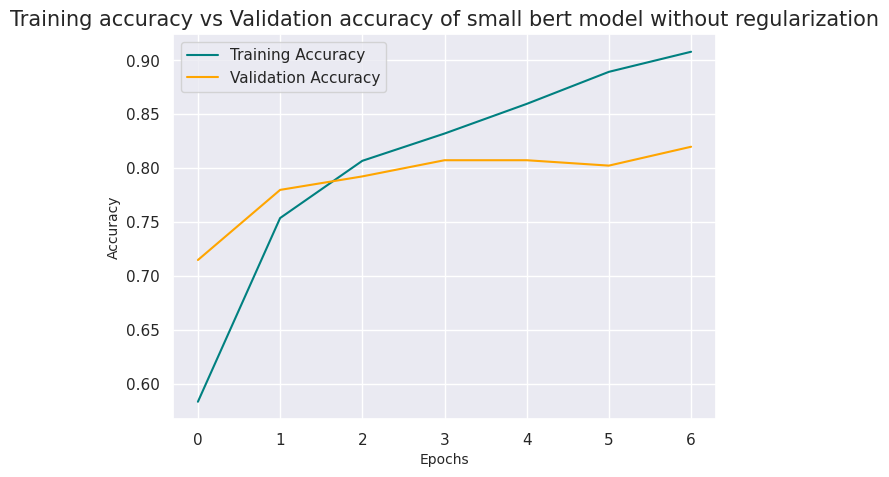

In [56]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training accuracy vs Validation accuracy of small bert model without regularization', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

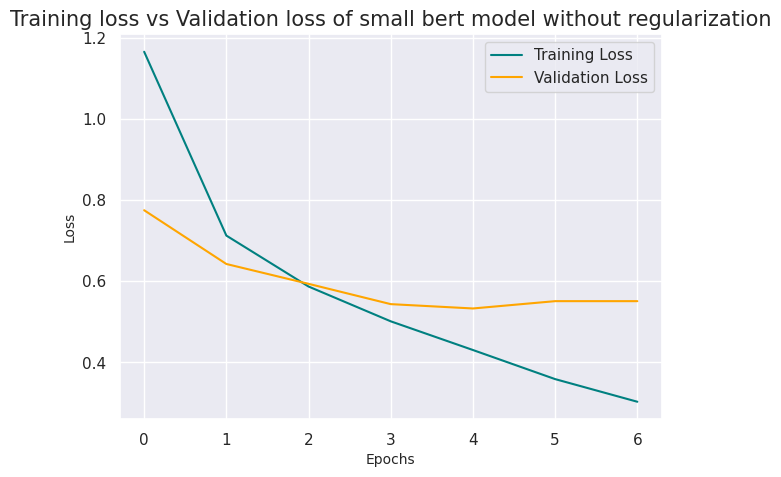

In [57]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training loss vs Validation loss of small bert model without regularization', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [62]:
small_bert_model_re = keras_nlp.models.BertClassifier.from_preset(
    'bert_small_en_uncased', preprocessor = preprocessor, num_classes = 5, dropout = 0.9
)

In [63]:
small_bert_model_re.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [64]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 1)

In [65]:
history2 = small_bert_model_re.fit(train_data, validation_data = valid_data, epochs = 100, callbacks = [early_stopping2])

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.2053 - loss: 1.7919 - val_accuracy: 0.6250 - val_loss: 1.3065
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.4408 - loss: 1.3359 - val_accuracy: 0.7150 - val_loss: 0.8728
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6650 - loss: 0.9891 - val_accuracy: 0.7325 - val_loss: 0.7407
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7243 - loss: 0.8082 - val_accuracy: 0.7575 - val_loss: 0.6738
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7611 - loss: 0.7405 - val_accuracy: 0.7575 - val_loss: 0.6348
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7848 - loss: 0.6563 - val_accuracy: 0.7850 - val_loss: 0.6107
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8041 - loss: 0.6008 - val_accuracy: 0.7975 - val_loss: 0.5650
Epoch 8/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8315 - loss: 0

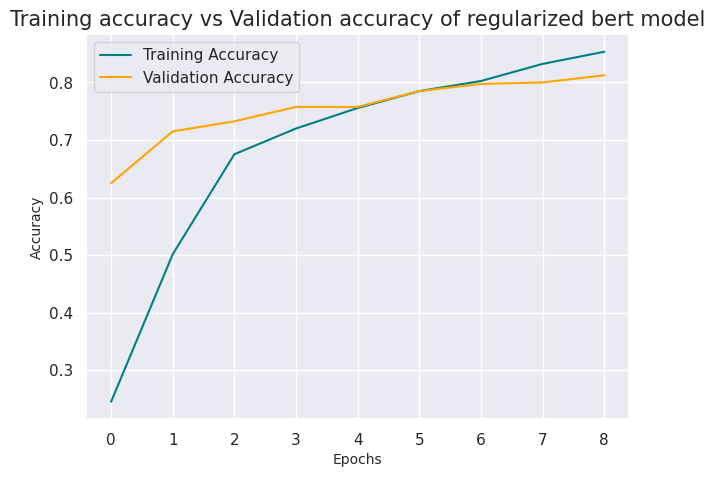

In [66]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history2.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training accuracy vs Validation accuracy of regularized bert model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

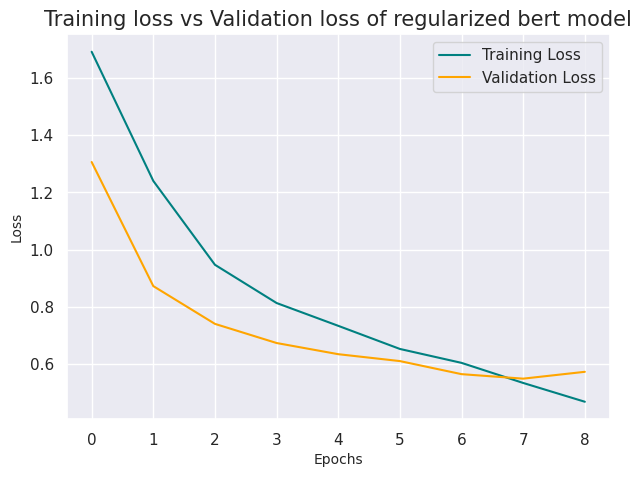

In [67]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training loss vs Validation loss of regularized bert model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [68]:
small_bert_model_re.evaluate(test_data)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7847 - loss: 0.6345


[0.6337507367134094, 0.796999990940094]

In [69]:
y_p = small_bert_model_re.predict(X_test_tensor)

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step


In [70]:
y_pred = [np.argmax(i) for i in y_p]

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       200
           1       0.77      0.81      0.79       200
           2       0.80      0.73      0.76       200
           3       0.83      0.78      0.80       200
           4       0.81      0.89      0.85       200

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



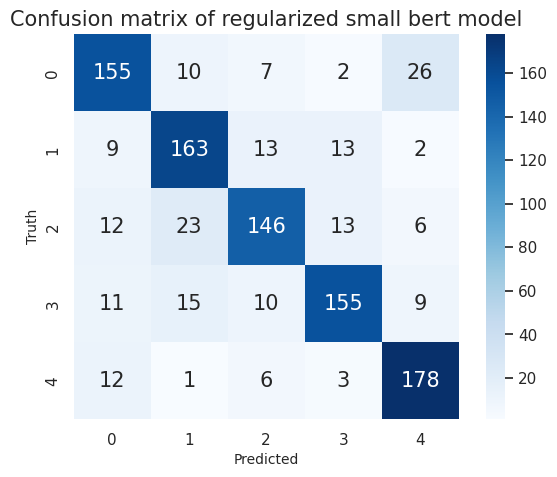

In [74]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, cbar = True, annot_kws = {'size': 15}, fmt = 'd', cmap = 'Blues')
plt.title('Confusion matrix of regularized small bert model', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()

In [98]:
tokenizer2 = keras_nlp.models.BertTokenizer.from_preset('bert_medium_en_uncased')

In [99]:
preprocessor2 = keras_nlp.models.BertPreprocessor(
    tokenizer2, sequence_length = 80, truncate = 'round_robin'
)

In [100]:
bert_medium_model_re = keras_nlp.models.BertClassifier.from_preset(
    'bert_medium_en_uncased', preprocessor = preprocessor2, dropout = 0.9, num_classes = 5
)

In [101]:
bert_medium_model_re.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [102]:
early_stopping3 = EarlyStopping(monitor = 'val_loss', patience = 1)

In [103]:
history3 = bert_meduim_model_re.fit(train_data, validation_data = valid_data, epochs = 100, callbacks = [early_stopping3])

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.2548 - sparse_categorical_accuracy: 0.9284 - val_loss: 0.8016 - val_sparse_categorical_accuracy: 0.7875
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.2210 - sparse_categorical_accuracy: 0.9394 - val_loss: 0.7081 - val_sparse_categorical_accuracy: 0.8025
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.1580 - sparse_categorical_accuracy: 0.9608 - val_loss: 0.7794 - val_sparse_categorical_accuracy: 0.7925


In [112]:
tokenizer3 = Tokenizer()

In [113]:
df_balanced.head()

,product,narrative,cleaned_text
0,credit_reporting,denied auto loan due negative account appearin...,deni auto loan due neg account appear credit r...
1,credit_reporting,im writing credit bureau complete investigatio...,im write credit bureau complet investig sent l...
2,credit_reporting,chance look credit report found derogatory acc...,chanc look credit report found derogatori acco...
3,credit_reporting,credit report reflect loan payment fact date c...,credit report reflect loan payment fact date c...
4,credit_reporting,called transunion customer service would help ...,call transunion custom servic would help take ...


In [166]:
tokenizer3.fit_on_texts(X_s)

In [167]:
seq = tokenizer3.texts_to_sequences(X_s)

In [168]:
vocab_size = len(tokenizer3.word_index) + 1
print('The vocab size is:', vocab_size)

The vocab size is: 8421


In [169]:
maxlen = max([len(i) for i in seq])
print('The maximum length of sentences in the dataset is:', maxlen)

The maximum length of sentences in the dataset is: 2684


In [170]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [171]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(pad_seq, y_s, test_size = 0.2, random_state = 101, shuffle = True, stratify = y_s)

In [172]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/glove-embeddings")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/glove-embeddings


In [173]:
os.listdir('/kaggle/input/glove-embeddings')

['glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.300d.txt',
 'glove.6B.100d.txt']

In [174]:
embedding_matrix = dict()
glove_file = open('/kaggle/input/glove-embeddings/glove.6B.100d.txt', encoding = 'utf8')
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_matrix[word] = vector
glove_file.close()

In [175]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer3.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [184]:
model = Sequential()

In [185]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(5)))
model.add(Dropout(0.2))
model.add(Dense(5, activation = 'softmax'))

In [186]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [187]:
early_stopping4 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [188]:
history4 = model.fit(X_train_t, y_train_t, validation_split = 0.2, epochs = 100, callbacks = [early_stopping4])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.2175 - loss: 1.6151 - val_accuracy: 0.3900 - val_loss: 1.5252
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.4084 - loss: 1.4758 - val_accuracy: 0.4975 - val_loss: 1.3684
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.5076 - loss: 1.3171 - val_accuracy: 0.5688 - val_loss: 1.2450
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.5800 - loss: 1.2192 - val_accuracy: 0.6212 - val_loss: 1.1507
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6253 - loss: 1.1149 - val_accuracy: 0.6288 - val_loss: 1.0972
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.5933 - loss: 1.1088 - val_accuracy: 0.6612 - val_loss: 1.0446
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.6198 - loss: 1.0393 - val_accuracy: 0.6612 - val_loss: 1.0045
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6506 -

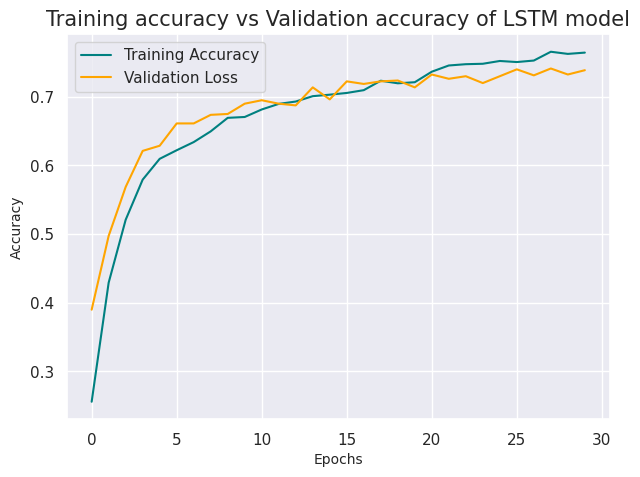

In [189]:
plt.figure(figsize = (7, 5))
plt.plot(history4.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history4.history['val_accuracy'], label = 'Validation Loss', color = 'orange')
plt.title('Training accuracy vs Validation accuracy of LSTM model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

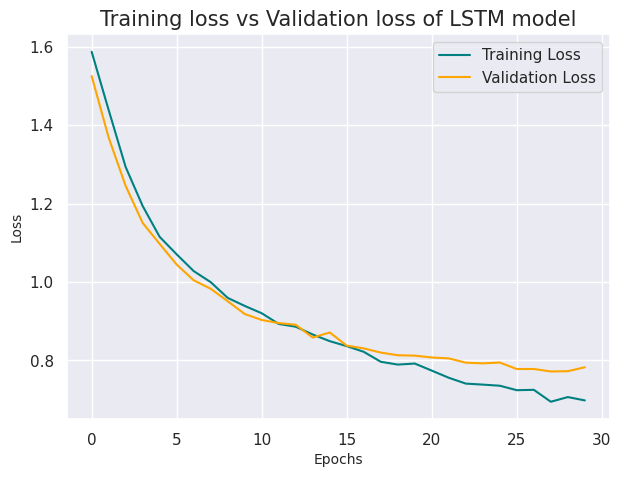

In [190]:
plt.figure(figsize = (7, 5))
plt.plot(history4.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history4.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training loss vs Validation loss of LSTM model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [191]:
model.evaluate(X_test_t, y_test_t)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7435 - loss: 0.7772


[0.7615023255348206, 0.7480000257492065]

In [192]:
y_p2 = model.predict(X_test_t)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


In [195]:
y_pred2 = [np.argmax(i) for i in y_p2]

In [196]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       200
           1       0.72      0.79      0.75       200
           2       0.76      0.65      0.70       200
           3       0.80      0.78      0.79       200
           4       0.73      0.81      0.77       200

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



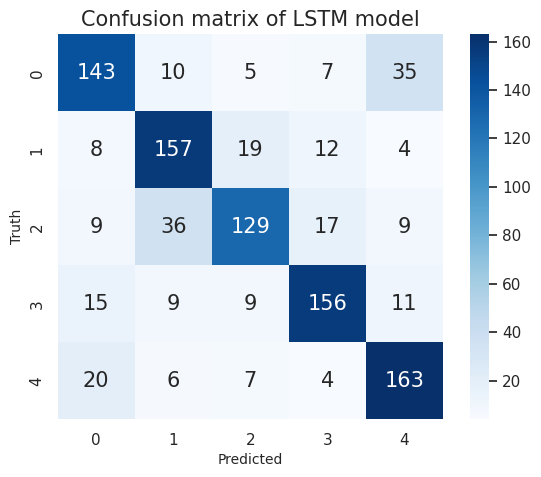

In [197]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test_t, y_pred2), annot = True, square = True, cbar = True, annot_kws = {'size': 15}, fmt = 'd', cmap = 'Blues')
plt.title('Confusion matrix of LSTM model', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()